In [1]:
import random
random.seed(42)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
#%config InlineBackend.figure_format = 'svg'

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We will take real time-series data of total ads watched by hour in one of our games.

In [2]:
df = pd.read_csv('../data/ads_hour.csv',index_col=['Date'], parse_dates=['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2085 entries, 2017-08-03 00:00:00 to 2017-10-28 20:00:00
Data columns (total 1 columns):
ads    2085 non-null int64
dtypes: int64(1)
memory usage: 32.6 KB


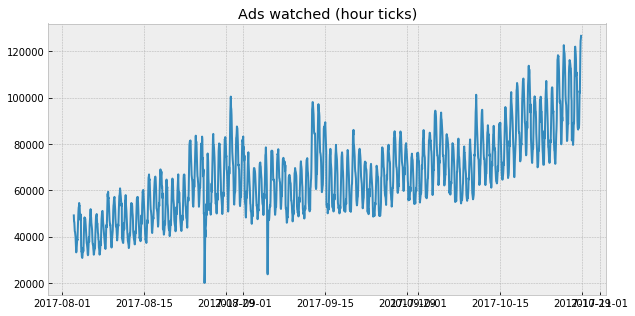

In [9]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(10, 5))
    plt.title('Ads watched (hour ticks)')
    plt.plot(df.ads);

We will use the already familiar prepareData function with some modifications - sine/cosine transformation for hour and dummy transformation for weekday features

In [10]:
def prepareData(data, lag_start=5, lag_end=14, test_size=0.15):
    """
    series: pd.DataFrame
        dataframe with timeseries

    lag_start: int
        initial step back in time to slice target variable 
        example - lag_start = 1 means that the model 
                  will see yesterday's values to predict today

    lag_end: int
        final step back in time to slice target variable
        example - lag_end = 4 means that the model 
                  will see up to 4 days back in time to predict today

    test_size: float
        size of the test dataset after train/test split as percentage of dataset

    """
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # calculate test index start position to split data on train test
    test_index = int(len(data) * (1 - test_size))
    
    # adding lags of original time series data as features
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    # transforming df index to datetime and creating new variables
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
        
    # since we will be using only linear models we need to get dummies from weekdays 
    # to avoid imposing weird algebraic rules on day numbers
    data = pd.concat([
        data.drop("weekday", axis=1), 
        pd.get_dummies(data['weekday'], prefix='weekday')
    ], axis=1)
        
    # encode hour with sin/cos transformation
    # credits - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    data['sin_hour'] = np.sin(2*np.pi*data['hour']/24)
    data['cos_hour'] = np.cos(2*np.pi*data['hour']/24)
    data.drop(["hour"], axis=1, inplace=True)
        

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # splitting whole dataset on train and test
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test



Use the functions on original df to prepare datasets necessary for model training. Reserve 30% of data for testing, use initial lag 12 and final lag 48. This way the model will be able to make forecasts twelve steps ahead, having observed data from the previous 1.5 day.

Scale the resulting datasets with the help of StandardScaler and create new variables - `X_train_scaled` and `X_test_scaled`. Don't forget that scaler should be trained on train set only to prevent information about future from leaking.


In [11]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=12, lag_end=48, test_size=0.3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now train a simple linear regression on scaled data:

In [12]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

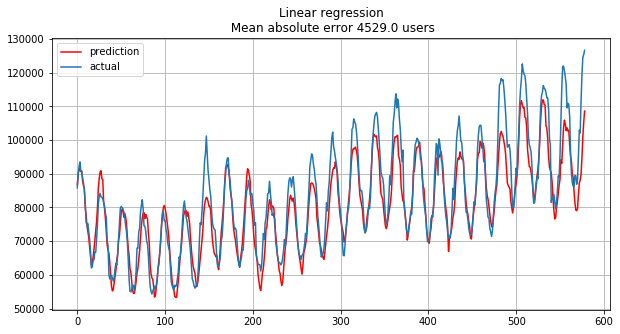

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Check the quality of the model on the training set via cross-validation. To do so you need to create an object-generator of time series cv folds with the help of `TimeSeriesSplit`. Set the number of folds to be equal to 5. Then use `cross_val_score`, feeding it's `cv` parameter with the created generator. Quality metrics should be `neg_mean_absolute_error`.

Don't forget to take an average of the result and multiply it by -1.

In [14]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [16]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=tscv, 
                            scoring='neg_mean_absolute_error', n_jobs=1)

Wall time: 17.9 ms


In [17]:
int(cv_scores.mean()*(-1))

4490

#### Answer(1): 4490



Now let's have a look at the forecast itself. We'll need `plotModelResults` function.


In [18]:
def plotModelResults(model, df_train, df_test, y_train, y_test, plot_intervals=False, scale=1.96, cv=tscv):
    """
    Plots modelled vs fact values
    
    model: fitted model 
    
    df_train, df_test: splitted featuresets
    
    y_train, y_test: targets
    
    plot_intervals: bool, if True, plot prediction intervals
    
    scale: float, sets the width of the intervals
    
    cv: cross validation method, needed for intervals
    
    """
    # making predictions for test
    prediction = model.predict(df_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        # calculate cv scores
        cv = cross_val_score(
            model, 
            df_train, 
            y_train, 
            cv=cv, 
            scoring="neg_mean_squared_error"
        )

        # calculate cv error deviation
        deviation = np.sqrt(cv.std())
        
        # calculate lower and upper intervals
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    # calculate overall quality on test set
    mae  = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

For model coefficients visualization use the following functions:

In [19]:
def getCoefficients(model):
    """Returns sorted coefficient values of the model"""
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    

def plotCoefficients(model):
    """Plots sorted coefficient values of the model"""
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(12, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()

Check the model results and plot the coefficients

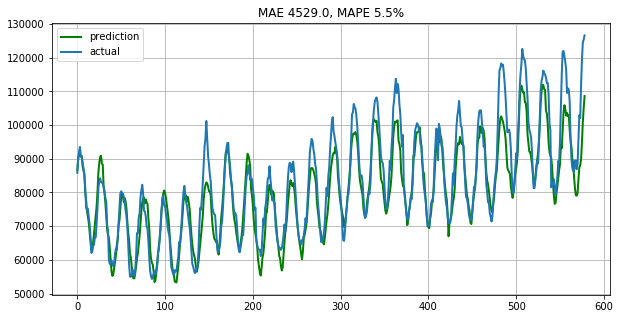

In [20]:
plotModelResults(lr, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=False, scale=1.96, cv=tscv)

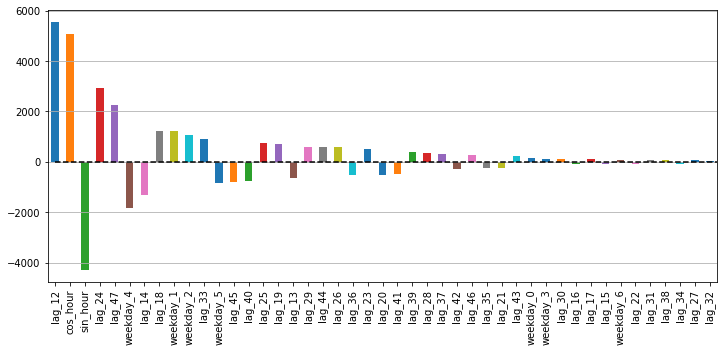

In [21]:
plotCoefficients(lr)

Wonderful, the intervals are plotted, forecast quality is great and everything seems to be fine, but...We might be having too many variables in our model and, possibly, some of them are not that important and can be dropped, reducing the dimentionality of data and reducing the chances of overfit. To make sure we have extra features, plot a heatmape of `X_train` data correlations with the help of `heatmap` function from seaborn library:

In [22]:
corr_train_matrix = X_train.corr()

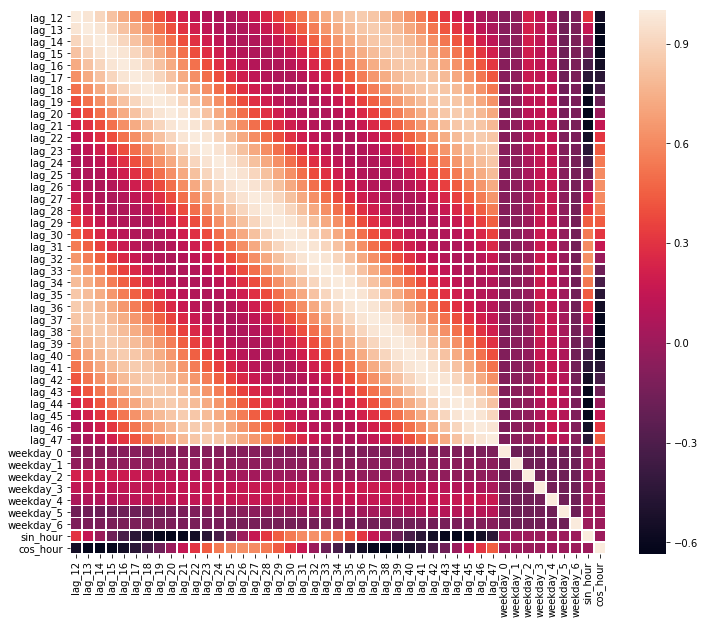

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_train_matrix,annot=False,linewidths=0.5);#,fmt='.1f',linewidths=0.5);

Indeed, features are highly correlated and you can even observe some kind of "seasonality" in those correlations on each 24-th lag. Let's try to add regularization to our models and remove some features.

Train Lasso regression on cross-validation (`LassoCV`) again feeding the `cv` parameter with the created generator-object.

Plot the forecast of the model and notice that the error on test dataset has not increased significantly


In [32]:
%%time
tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

#prediction = lasso.predict(X_test_scaled)

Wall time: 110 ms


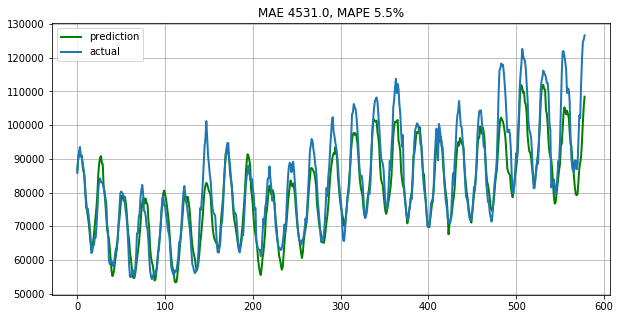

In [33]:
plotModelResults(lasso, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=False, scale=1.96, cv=tscv)

Perfect, we are still having practically the same model quality, while having less features. Use the function `getCoefficients` and find, how many features are now dropped (coefficient equals zero).

In [46]:
getCoefficients(lasso).coef==0.000000

cos_hour     False
lag_12       False
sin_hour     False
lag_24       False
lag_47       False
weekday_4    False
lag_14       False
weekday_1    False
lag_18       False
weekday_5    False
weekday_2    False
lag_25       False
lag_40       False
lag_29       False
lag_28       False
lag_26       False
lag_33       False
lag_19       False
lag_41       False
lag_31       False
lag_36       False
lag_23       False
lag_30       False
lag_15       False
lag_32       False
lag_27       False
weekday_0    False
weekday_6    False
weekday_3     True
lag_44        True
lag_46        True
lag_45        True
lag_35        True
lag_43        True
lag_42        True
lag_39        True
lag_38        True
lag_37        True
lag_13        True
lag_22        True
lag_21        True
lag_20        True
lag_17        True
lag_16        True
lag_34        True
Name: coef, dtype: bool

#### Task 2. How many coefficients of Lasso model equal zero? (with 6 digit precision)?

In [47]:
np.sum(np.abs(getCoefficients(lasso)).coef==0.000000).astype('int64')

17

#### Answer(2): 17

Alright, we have some features dropped. But what if we want to go further and transform our linear-dependant features into more compact representation? To do so we'll use principal component analysis.

In [49]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

def plotPCA(pca):
    """
    Plots accumulated percentage of explained variance by component
    
    pca: fitted PCA object
    """
    components = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    plt.figure(figsize=(20, 10))
    plt.bar(components, variance)
    
    # additionally mark the level of 95% of explained variance 
    plt.hlines(y = 95, xmin=0, xmax=len(components), linestyles='dashed', colors='red')
    
    plt.xlabel('PCA components')
    plt.ylabel('variance')
    plt.xticks(components)
    plt.show()

In [58]:
X_train.shape

(1460, 45)

#### Task 3. What is the minimal number of components needed to explain at least 95% of variance of the train dataset?

In [52]:
pca = PCA()
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

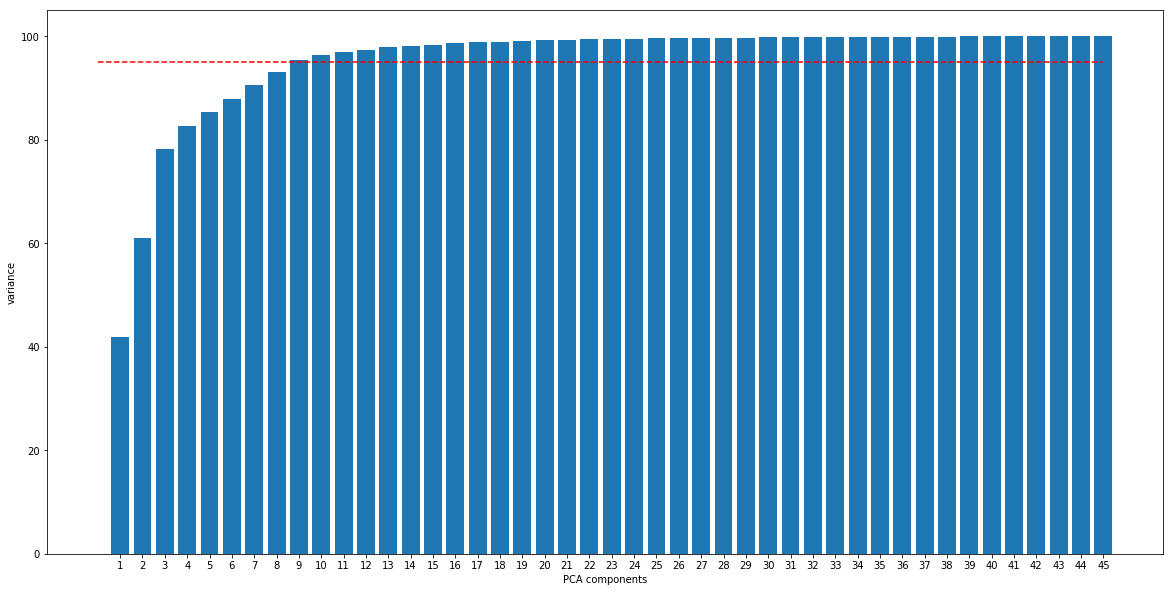

In [53]:
plotPCA(pca)

9 principal components explain 95.34% of variance


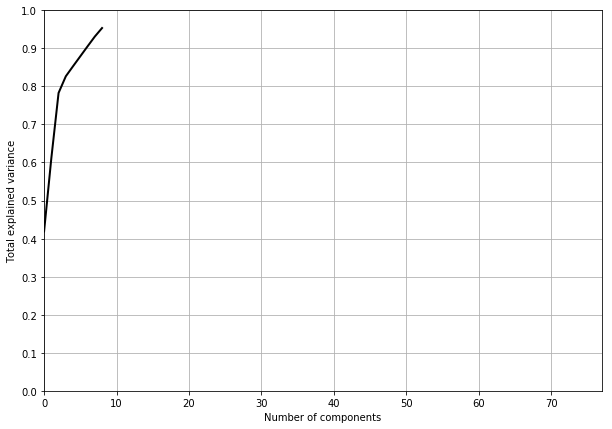

In [62]:
pca = PCA(n_components=9).fit(X_train_scaled)#, svd_solver='randomized', random_state=1).fit(X_train_scaled)

print('9 principal components explain %.2f%% of variance' %
      (100 * np.cumsum(pca.explained_variance_ratio_)[-1]))
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=2, color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 77)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.show()

In [64]:
pca = PCA(0.95).fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)
X_pca.shape[1]

9

#### Answer(3): 9

Create the `pca` object once again, this time setting inside it the optimal number of components (explaining at least 95% of variance). After that create two new variables - `pca_features_train` and `pca_features_test`, assigning to them pca-transformed scaled datasets.


In [66]:
pca = PCA(0.95)
pca_features_train = pca.fit_transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

Now train linear regression on pca features and plot its forecast.

#### Task 4. What is the MAE of linear regression, trained on pca-transformed features?

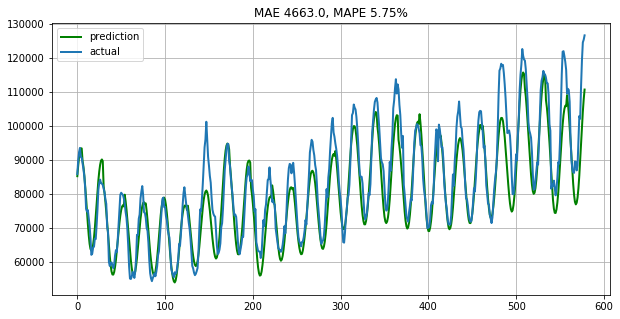

In [69]:
lr = LinearRegression()
lr.fit(pca_features_train, y_train)

plotModelResults(lr, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=False, scale=1.96, cv=tscv)

#### Answer(4): 4663